# Cluster Cyclists and Determine a Starting Pint

## Assumptions

I'm going to make some general assumptions about cycling:
1. Cyclists generally start their rides from home 
2. Some cyclists may have more than one set of longitute/latitude, which may mean they either cycle with other people already, or they don't start from the same location
3. If a cyclist has multiple rides and all the rides have different starting points, we can assume the cyclist goes to those starting points in some manner. For our purposes, we will use central_location as a measure of equal or as equal distance from all points from each other

## Personal Notes

1. My first assumption was to take the average locations of cyclists with multiple rides, and my reasoning was if they cyclicsts are cycling from points that are say within 15km from each other, then they must be starting from some place that connects those points.
2. My first attempt was to see if there are cyclists within 10-15 km of a specific cyclist, and the reasoning was if a cyclist spends 1, 1.5 minuts per km to go to a place, then that might be 15 minutes they wouldn't mind cycling to for an event. But if the event is 50 km, I thought cycling for more than 15 minutes to go to a starting point might be too much to ask of a user. My first attempt ended up with me in tears because I realised that it takes seven hundred centuries to do that with my very naive method.
3. Two starting points have about 2000 potential members each. This is potentially cumbersome, because how would 2000 people arrive on the starting point without different starting times? So maybe if we had a temporal column I could add a starting time as well, like on Zwift. Also, there are starting points with very few cyclists, and the point of the event is probably to ride together, so in some potential next steps, I would deal with that.
6. I didn't want to work with Berlin specifically and try to see central points of the specific city, where things are, whether the starting points are close to a bike path, a coffee shop, a carb shop (hehe), something that a lot of cyclists frequent, because I wanted to make it city-agnostic and just look at the data in the csv.

In [248]:
# Let's first import some libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import h3
import folium
from shapely.geometry import Polygon, Point, mapping, LineString
from libpysal import weights
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from geopandas import GeoDataFrame
import shapely

In [249]:
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

In [250]:
## Define the look of the Seaborn plots
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,8)})
sns.set(font_scale = 1.5)

In [251]:
df = pd.read_csv("tours.csv")

In [252]:
df.head()

user_id   latitude  longitude
0  0280088d  52.552575  13.443113
1  0280088d  52.552958  13.442784
2  a6468bc1  52.457977  12.843970
3  0280088d  52.552796  13.441866
4  49b2ce0a  52.486855  13.551305

In [253]:
# Let's first create a columns called number_of_races to state how many rides that rider has, so we can 
# analyze them
df['number_of_rides'] = df.groupby('user_id')['user_id'].transform('count')

In [254]:
# Let's see if it worked
df.head()

user_id   latitude  longitude  number_of_rides
0  0280088d  52.552575  13.443113                5
1  0280088d  52.552958  13.442784                5
2  a6468bc1  52.457977  12.843970                1
3  0280088d  52.552796  13.441866                5
4  49b2ce0a  52.486855  13.551305                1

In [255]:
# Let's create a column called same_starting_point that's a binary flag: 0 if it's a different starting point
# and 1 if it's the same starting point
mask = df.groupby('user_id')[['latitude', 'longitude']].apply(lambda x: x.nunique().eq(1)).all(axis=1)

df['same_starting_point'] = df['user_id'].isin(mask[mask].index).astype(int)

In [256]:
# Let's see if it worked
df.head()

user_id   latitude  longitude  number_of_rides  same_starting_point
0  0280088d  52.552575  13.443113                5                    0
1  0280088d  52.552958  13.442784                5                    0
2  a6468bc1  52.457977  12.843970                1                    1
3  0280088d  52.552796  13.441866                5                    0
4  49b2ce0a  52.486855  13.551305                1                    1

In [257]:
# For cyclists that have more than one ride, let's see if it's the same starting point. If not, how far
# they are between each other
df[(df['number_of_rides'] > 1) & (df['same_starting_point'] == 0)]['user_id'].value_counts()

user_id
269b9a0c    10
a0d45cf4    10
85604de4    10
40db6af2    10
4c71fa12    10
fed7b47a    10
0614ef86    10
738826d3    10
86c04176    10
4ad32158    10
1066260c    10
c76d38a6    10
7c1e1c6e    10
e4d2d6ef    10
c158a310    10
28a01694    10
91a23966    10
eb794b24    10
7c63602f    10
71ed8c3d    10
cef53816    10
17f8637e    10
dce1949c    10
55579765    10
1433bf55    10
08feccc9    10
d09103eb    10
6e28ec74    10
5ff19f36    10
e15ab6cf    10
848e47fe    10
a4561605    10
4ad0d8ff    10
61f78a44    10
89c8ec27    10
4c1d2370    10
5e1bad97    10
0000571b    10
a998a728    10
b8722ad4    10
546d7758    10
ed110b28    10
af9052f7    10
674d6cee    10
5d4b3bb2    10
d4f1df30    10
766aeac3    10
4511aff5    10
29eb6e69    10
d535c8c9    10
0dad20a0    10
0ab0a46d    10
95ed80d7    10
998b6349    10
ef43430f    10
e802f841    10
f6f49a5b    10
7c0cfed2    10
9bd74434     9
e47cc3c7     9
2ff695c7     9
8e76a93f     9
721ed364     9
280f4934     9
e177d8fd     9
d823df64     9
f4

In [258]:
df[df['user_id'] == '269b9a0c']

user_id   latitude  longitude  number_of_rides  same_starting_point
16477  269b9a0c  52.539767  13.362440               10                    0
16479  269b9a0c  52.539553  13.362712               10                    0
16487  269b9a0c  52.469434  13.481758               10                    0
16493  269b9a0c  52.539541  13.362916               10                    0
16529  269b9a0c  52.504863  13.427815               10                    0
16539  269b9a0c  52.531265  13.432902               10                    0
17385  269b9a0c  52.538896  13.360333               10                    0
17388  269b9a0c  52.531353  13.432896               10                    0
17399  269b9a0c  52.543652  13.356033               10                    0
17412  269b9a0c  52.532847  13.435074               10                    0

In [259]:
### Let's see how many cyclists have the same starting point and how many have different starting points
df.groupby('same_starting_point').user_id.nunique()

same_starting_point
0    3911
1    5721
Name: user_id, dtype: int64

In [260]:
# Let's create a column called distance_between_rides to denote how far from each other the starting points
# are for people with multiple rides

# first, let's create a coordinate out of the latitude and longitude, because we will need this to
# take the difference between two coordinates in km
df['coordinate_point'] = list(zip(df['latitude'], df['longitude']))

In [261]:
df.head()

user_id   latitude  longitude  number_of_rides  same_starting_point  \
0  0280088d  52.552575  13.443113                5                    0   
1  0280088d  52.552958  13.442784                5                    0   
2  a6468bc1  52.457977  12.843970                1                    1   
3  0280088d  52.552796  13.441866                5                    0   
4  49b2ce0a  52.486855  13.551305                1                    1   

                           coordinate_point  
0   (52.55257478574303, 13.443112653090516)  
1   (52.55295831996743, 13.442784015278116)  
2  (52.457976893585474, 12.843970370963142)  
3   (52.55279590199793, 13.441865778202416)  
4   (52.48685496195008, 13.551305012691357)

In [262]:
# next, let's create a column called next_ride_coordinate so we can take the difference for each user
df = df.sort_values(by=['user_id'])

# Create a new column 'next_ride_coordinate' with the next row's 'coordinate_point' for each user
df['next_ride_coordinate'] = df.groupby('user_id')['coordinate_point'].shift(-1)


In [263]:
df.head()

user_id   latitude  longitude  number_of_rides  same_starting_point  \
17217  0000571b  52.437748  13.807098               10                    0   
17219  0000571b  52.453703  13.582331               10                    0   
17218  0000571b  52.418764  13.808191               10                    0   
5085   0000571b  52.467889  13.562555               10                    0   
9194   0000571b  52.464814  13.858726               10                    0   

                              coordinate_point  \
17217  (52.43774846898206, 13.807097666976343)   
17219  (52.45370253751906, 13.582331178691645)   
17218  (52.41876409544656, 13.808190985406446)   
5085   (52.46788880950156, 13.562554777653745)   
9194   (52.46481360235066, 13.858726141500345)   

                          next_ride_coordinate  
17217  (52.45370253751906, 13.582331178691645)  
17219  (52.41876409544656, 13.808190985406446)  
17218  (52.46788880950156, 13.562554777653745)  
5085   (52.46481360235066, 13.858726141500345)  
9194   (52.58887462332606, 13.865564745221246)

In [264]:
df.isnull().sum()

user_id                    0
latitude                   0
longitude                  0
number_of_rides            0
same_starting_point        0
coordinate_point           0
next_ride_coordinate    9632
dtype: int64

In [265]:
df[df['next_ride_coordinate'].isnull()]

user_id   latitude  longitude  number_of_rides  same_starting_point  \
11650  0000571b  52.405967  13.688889               10                    0   
8224   0001699f  52.555009  13.424564                1                    1   
10627  00060476  52.484604  13.311919                1                    1   
7164   0006963f  52.719423  13.259965                1                    1   
17506  000e8618  52.470330  13.306235                1                    1   
13903  00100080  52.479634  13.522519                1                    1   
9295   0012a1d7  52.438419  13.573708                3                    0   
16445  001ec939  52.437298  13.323598                2                    0   
13707  0023c61a  52.544509  13.397796                1                    1   
16288  002679aa  52.400903  13.047131                4                    0   
11452  002a0c95  52.328888  12.991435                1                    1   
10089  002cc0e1  52.397143  13.085383                1                    1   
15979  00306b86  52.641454  13.326855                1                    1   
8753   0039f677  52.611414  13.558019                1                    1   
11800  003cf9b5  52.381124  13.518556                1                    1   
2809   0040c551  52.511057  13.422634                1                    1   
15709  004c2d35  52.277300  13.025720                1                    1   
9883   0056f1b4  52.644669  13.162891                1                    1   
5092   006112de  52.553523  13.423083                1                    1   
16416  00644e54  52.607436  13.393817                1                    1   
10546  006d1add  52.458013  13.217324                1                    1   
5825   006dadee  52.466699  13.425861                4                    0   
7119   0074eb4b  52.450035  13.322233                4                    0   
18899  007a0a5f  52.573681  13.380306                3                    0   
1026   007b8e0f  52.471153  13.446102                1                    1   
14519  0085aa22  52.465132  13.138450                1                    1   
8511   008c981a  52.275340  13.247589                1                    1   
17020  008ff567  52.437003  13.436583                1                    1   
6445   009845e7  52.401185  13.073654                1                    1   
8656   00984f9a  52.631588  13.357864                4                    0   
1802   009a0f6b  52.504894  13.257309                3                    0   
9942   009a427c  52.644332  13.296685                1                    1   
18675  009a8f93  52.476338  13.415193                3                    0   
9862   009adf0f  52.478477  13.360365                1                    1   
1114   009bdef2  52.554553  13.436261                3                    0   
14046  00aa4412  52.506797  13.300220                8                    0   
17163  00abec00  52.254454  13.949758                1                    1   
5887   00af83a4  52.524015  13.415915                1                    1   
7585   00b3a5e7  52.294050  13.039501                1                    1   
18766  00b8012f  52.632578  12.890768                1                    1   
7977   00c6f7f7  52.531042  13.428031                4                    0   
7150   00c7c590  52.440215  13.767050                1                    1   
7074   00d0d55d  52.344903  13.087993                3                    0   
4281   00d31395  52.296809  13.597793                2                    0   
3694   00d4b774  52.639851  13.272508                1                    1   
11533  00d70f77  52.393009  13.661432                2                    0   
15231  00d7d0e9  52.390281  13.285380                1                    1   
4017   00da41b7  52.479954  13.367000                1                    1   
3622   00e1bcd2  52.516476  13.476367                3                    0   
8204   00f34ad2  52.492670  13.174555                2    

In [266]:
# Fill the 'next_ride_coordinate' for the last row of each user with the last coordinate point
df['next_ride_coordinate'] = df.groupby('user_id')['next_ride_coordinate'].ffill()

In [267]:
# For users with only one ride, assign the location_tuple to the next_ride_coordinate
single_ride_users = df['user_id'][df['number_of_rides'] == 1].unique()
df.loc[df['user_id'].isin(single_ride_users), 'next_ride_coordinate'] = df['coordinate_point']

In [268]:
# finally, let's create the distance_between_rides column
from geopy.distance import geodesic
df['distance_between_rides'] = df.apply(lambda row: geodesic(row['coordinate_point'], row['next_ride_coordinate']).kilometers, axis=1)

In [269]:
# Let's see if that worked
df.head()

user_id   latitude  longitude  number_of_rides  same_starting_point  \
17217  0000571b  52.437748  13.807098               10                    0   
17219  0000571b  52.453703  13.582331               10                    0   
17218  0000571b  52.418764  13.808191               10                    0   
5085   0000571b  52.467889  13.562555               10                    0   
9194   0000571b  52.464814  13.858726               10                    0   

                              coordinate_point  \
17217  (52.43774846898206, 13.807097666976343)   
17219  (52.45370253751906, 13.582331178691645)   
17218  (52.41876409544656, 13.808190985406446)   
5085   (52.46788880950156, 13.562554777653745)   
9194   (52.46481360235066, 13.858726141500345)   

                          next_ride_coordinate  distance_between_rides  
17217  (52.45370253751906, 13.582331178691645)               15.385495  
17219  (52.41876409544656, 13.808190985406446)               15.844741  
17218  (52.46788880950156, 13.562554777653745)               17.574404  
5085   (52.46481360235066, 13.858726141500345)               20.131313  
9194   (52.58887462332606, 13.865564745221246)               13.812980

In [270]:
# Let's create a new column called central_location for users that have multiple rides. The assumption is,
# maybe the cyclist starts from this central location and goes to a starting point to cycle

# Function to calculate the centroid for a set of coordinates
def calculate_centroid(locations):
    num_points = len(locations)
    
    if num_points == 0:
        return None
    
    avg_latitude = sum(lat for lat, lon in locations) / num_points
    avg_longitude = sum(lon for lat, lon in locations) / num_points
    
    return avg_latitude, avg_longitude

# Group by user_id and apply the calculate_centroid function to each user's location tuples
centroid = df.groupby('user_id')['coordinate_point'].apply(calculate_centroid)


In [271]:
# Merge the calculated centroids back to the original DataFrame
df = df.merge(centroid.rename('central_location'), left_on='user_id', right_index=True)

In [272]:
# Let's see what that did
df.head()

user_id   latitude  longitude  number_of_rides  same_starting_point  \
17217  0000571b  52.437748  13.807098               10                    0   
17219  0000571b  52.453703  13.582331               10                    0   
17218  0000571b  52.418764  13.808191               10                    0   
5085   0000571b  52.467889  13.562555               10                    0   
9194   0000571b  52.464814  13.858726               10                    0   

                              coordinate_point  \
17217  (52.43774846898206, 13.807097666976343)   
17219  (52.45370253751906, 13.582331178691645)   
17218  (52.41876409544656, 13.808190985406446)   
5085   (52.46788880950156, 13.562554777653745)   
9194   (52.46481360235066, 13.858726141500345)   

                          next_ride_coordinate  distance_between_rides  \
17217  (52.45370253751906, 13.582331178691645)               15.385495   
17219  (52.41876409544656, 13.808190985406446)               15.844741   
17218  (52.46788880950156, 13.562554777653745)               17.574404   
5085   (52.46481360235066, 13.858726141500345)               20.131313   
9194   (52.58887462332606, 13.865564745221246)               13.812980   

                              central_location  
17217  (52.47005854807723, 13.554256376488713)  
17219  (52.47005854807723, 13.554256376488713)  
17218  (52.47005854807723, 13.554256376488713)  
5085   (52.47005854807723, 13.554256376488713)  
9194   (52.47005854807723, 13.554256376488713)

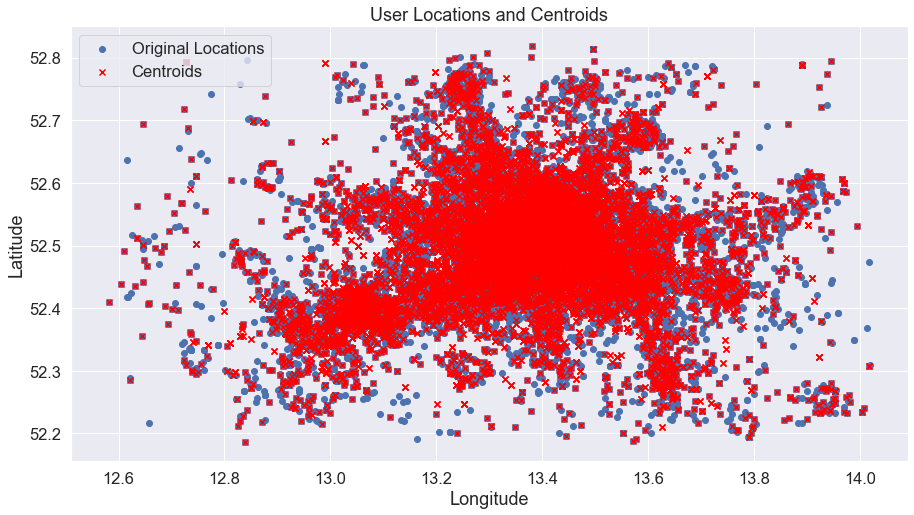

In [273]:
# Let's see if cyclists' central location is close

# Unpack centroid tuples into separate latitude and longitude columns
df['centroid_latitude'], df['centroid_longitude'] = zip(*df['central_location'])

# Scatter plot of original locations and centroids
plt.scatter(df['longitude'], df['latitude'], label='Original Locations')
plt.scatter(df['centroid_longitude'], df['centroid_latitude'], color='red', marker='x', label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('User Locations and Centroids')
plt.show()

In [274]:
df = df.drop_duplicates(subset=['user_id', 'centroid_latitude', 'centroid_longitude'])

In [275]:
df.head()

user_id   latitude  longitude  number_of_rides  same_starting_point  \
17217  0000571b  52.437748  13.807098               10                    0   
8224   0001699f  52.555009  13.424564                1                    1   
10627  00060476  52.484604  13.311919                1                    1   
7164   0006963f  52.719423  13.259965                1                    1   
17506  000e8618  52.470330  13.306235                1                    1   

                               coordinate_point  \
17217   (52.43774846898206, 13.807097666976343)   
8224    (52.55500915761778, 13.424563893602798)   
10627   (52.48460350134171, 13.311919469159404)   
7164   (52.719422766983946, 13.259964804968094)   
17506     (52.4703299940124, 13.30623513833248)   

                           next_ride_coordinate  distance_between_rides  \
17217   (52.45370253751906, 13.582331178691645)               15.385495   
8224    (52.55500915761778, 13.424563893602798)                0.000000   
10627   (52.48460350134171, 13.311919469159404)                0.000000   
7164   (52.719422766983946, 13.259964804968094)                0.000000   
17506     (52.4703299940124, 13.30623513833248)                0.000000   

                               central_location  centroid_latitude  \
17217   (52.47005854807723, 13.554256376488713)          52.470059   
8224    (52.55500915761778, 13.424563893602798)          52.555009   
10627   (52.48460350134171, 13.311919469159404)          52.484604   
7164   (52.719422766983946, 13.259964804968094)          52.719423   
17506     (52.4703299940124, 13.30623513833248)          52.470330   

       centroid_longitude  
17217           13.554256  
8224            13.424564  
10627           13.311919  
7164            13.259965  
17506           13.306235

In [276]:
df = df.drop(columns=['latitude', 'longitude', 'number_of_rides', 'same_starting_point', 'coordinate_point',
                       'next_ride_coordinate', 'distance_between_rides'])

In [277]:
df.head()

user_id                          central_location  centroid_latitude  \
17217  0000571b   (52.47005854807723, 13.554256376488713)          52.470059   
8224   0001699f   (52.55500915761778, 13.424563893602798)          52.555009   
10627  00060476   (52.48460350134171, 13.311919469159404)          52.484604   
7164   0006963f  (52.719422766983946, 13.259964804968094)          52.719423   
17506  000e8618     (52.4703299940124, 13.30623513833248)          52.470330   

       centroid_longitude  
17217           13.554256  
8224            13.424564  
10627           13.311919  
7164            13.259965  
17506           13.306235

In [278]:
geometry = [Point(xy) for xy in df['central_location']]
gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

In [279]:
gdf.head()

user_id                          central_location  centroid_latitude  \
17217  0000571b   (52.47005854807723, 13.554256376488713)          52.470059   
8224   0001699f   (52.55500915761778, 13.424563893602798)          52.555009   
10627  00060476   (52.48460350134171, 13.311919469159404)          52.484604   
7164   0006963f  (52.719422766983946, 13.259964804968094)          52.719423   
17506  000e8618     (52.4703299940124, 13.30623513833248)          52.470330   

       centroid_longitude                   geometry  
17217           13.554256  POINT (52.47006 13.55426)  
8224            13.424564  POINT (52.55501 13.42456)  
10627           13.311919  POINT (52.48460 13.31192)  
7164            13.259965  POINT (52.71942 13.25996)  
17506           13.306235  POINT (52.47033 13.30624)

In [280]:
def get_hexagon_grid(latitude, longitude, resolution, ring_size):
    # Get the H3 hexagons covering the specified location
    center_h3 = h3.geo_to_h3(latitude, longitude, resolution)
    hexagons = list(h3.k_ring(center_h3, ring_size))  

    # Create a GeoDataFrame with hexagons and their corresponding geometries
    hexagon_geometries = [shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
    hexagon_df = gpd.GeoDataFrame({'hexagon_id': hexagons, 'geometry': hexagon_geometries})

    return hexagon_df

In [281]:

# Latitude and longitude coordinates for the center of the area
center_lat = gdf['centroid_latitude'].mean()
center_lng = gdf['centroid_longitude'].mean()


In [282]:
# Generate H3 hexagons at a specified resolution 
resolution = 5

# Indicate the number of rings around the central hexagon
ring_size = 4 # I tried a lot of these before I settled for this number, everything below returned null hexagons for some people                            

In [283]:
# Hexagon grid around the area in the dataset
hexagon_df = get_hexagon_grid(center_lat, center_lng, resolution, ring_size)

# Visualize the first rows of the GeoDataFrame
hexagon_df.head()

hexagon_id  \
0  851f18bbfffffff   
1  851f1d47fffffff   
2  851f1c27fffffff   
3  851f1d77fffffff   
4  851f1d67fffffff   

                                                                                                                                          geometry  
0  POLYGON ((13.17609 52.32704, 13.18244 52.24665, 13.30880 52.21410, 13.42905 52.26189, 13.42298 52.34231, 13.29638 52.37491, 13.17609 52.32704))  
1  POLYGON ((13.51973 52.71045, 13.52571 52.63048, 13.65279 52.59781, 13.77411 52.64508, 13.76842 52.72508, 13.64111 52.75779, 13.51973 52.71045))  
2  POLYGON ((12.88933 52.79130, 12.89607 52.71155, 13.02332 52.67966, 13.14408 52.72747, 13.13764 52.80725, 13.01014 52.83919, 12.88933 52.79130))  
3  POLYGON ((14.01742 52.73921, 14.02282 52.65918, 14.14991 52.62597, 14.27183 52.67276, 14.26673 52.75281, 14.13941 52.78606, 14.01742 52.73921))  
4  POLYGON ((14.14991 52.62597, 14.15514 52.54578, 14.28200 52.51234, 14.40386 52.55906, 14.39893 52.63928, 14.27183 52.67276, 14.14991 52.62597))

In [284]:
hexagon_df.hexagon_id.nunique()

61

In [285]:
def calculate_hexagon_ids(df, hexagon_df):

    # Create a column hexagon_id with the id of the hexagon, hexagon_center_latitude, and hexagon_center_longitude
    df['hexagon_id'] = None
    df['hexagon_center_latitude'] = None
    df['hexagon_center_longitude'] = None

    # Iterate through the rides and assign them to a hexagon
    for i, user in df.iterrows():
        point = Point(user["centroid_longitude"], user["centroid_latitude"]) 
        for _, row in hexagon_df.iterrows():
            if point.within(row['geometry']):
                df.loc[i, 'hexagon_id'] = row['hexagon_id']
                df.loc[i, 'hexagon_center_latitude'] = row['geometry'].centroid.y
                df.loc[i, 'hexagon_center_longitude'] = row['geometry'].centroid.x
    
    return df

In [286]:
result = calculate_hexagon_ids(df, hexagon_df)

In [287]:
result.head()

user_id                          central_location  centroid_latitude  \
17217  0000571b   (52.47005854807723, 13.554256376488713)          52.470059   
8224   0001699f   (52.55500915761778, 13.424563893602798)          52.555009   
10627  00060476   (52.48460350134171, 13.311919469159404)          52.484604   
7164   0006963f  (52.719422766983946, 13.259964804968094)          52.719423   
17506  000e8618     (52.4703299940124, 13.30623513833248)          52.470330   

       centroid_longitude       hexagon_id hexagon_center_latitude  \
17217           13.554256  851f18b7fffffff               52.437378   
8224            13.424564  851f1d4ffffffff               52.550353   
10627           13.311919  851f1d4bfffffff               52.535266   
7164            13.259965  851f1d53fffffff               52.775108   
17506           13.306235  851f1d4bfffffff               52.535266   

      hexagon_center_longitude  
17217                13.664443  
8224                 13.531718  
10627                13.283935  
7164                 13.265102  
17506                13.283935

In [288]:
result.hexagon_id.isnull().sum()

0

In [289]:
result.hexagon_id.nunique()

37

In [290]:
result.hexagon_id.value_counts()

hexagon_id
851f1d4bfffffff    2187
851f1d4ffffffff    1914
851f18b3fffffff    1491
851f1887fffffff     923
851f18b7fffffff     602
851f1d43fffffff     426
851f1883fffffff     381
851f1897fffffff     229
851f18a3fffffff     207
851f1d5bfffffff     183
851f1d7bfffffff     157
851f1d53fffffff     148
851f1d47fffffff     139
851f18bbfffffff     118
851f188ffffffff     114
851f1d57fffffff      53
851f188bfffffff      43
851f18affffffff      42
851f19dbfffffff      39
851f1c2ffffffff      37
851f18a7fffffff      35
851f1893fffffff      34
851f1d6bfffffff      25
851f1d63fffffff      20
851f189bfffffff      17
851f1c27fffffff      15
851f18abfffffff       9
851f1c2bfffffff       8
851f1d0bfffffff       8
851f1c67fffffff       6
851f1c23fffffff       5
851f1d73fffffff       4
851f1817fffffff       3
851f19d3fffffff       3
851f1d0ffffffff       3
851f1813fffffff       3
851f18d7fffffff       1
Name: count, dtype: int64

In [291]:
# Convert hexagon column to categorical and get integer codes
hexagon_categories = pd.Categorical(result['hexagon_id'])
result['hexagon_id'] = hexagon_categories.codes + 1  # Adding 1 to start indexing from 1

In [292]:
result.head()

user_id                          central_location  centroid_latitude  \
17217  0000571b   (52.47005854807723, 13.554256376488713)          52.470059   
8224   0001699f   (52.55500915761778, 13.424563893602798)          52.555009   
10627  00060476   (52.48460350134171, 13.311919469159404)          52.484604   
7164   0006963f  (52.719422766983946, 13.259964804968094)          52.719423   
17506  000e8618     (52.4703299940124, 13.30623513833248)          52.470330   

       centroid_longitude  hexagon_id hexagon_center_latitude  \
17217           13.554256          15               52.437378   
8224            13.424564          30               52.550353   
10627           13.311919          29               52.535266   
7164            13.259965          31               52.775108   
17506           13.306235          29               52.535266   

      hexagon_center_longitude  
17217                13.664443  
8224                 13.531718  
10627                13.283935  
7164                 13.265102  
17506                13.283935

In [293]:
# Group by 'hexagon_id' and aggregate 'user_id' into a list for each group
grouped_data = result.groupby('hexagon_id')['user_id'].agg(list).reset_index()

# Merge the aggregated data back into the original df
result = pd.merge(result, grouped_data, on='hexagon_id', how='left', suffixes=('', '_group'))

# Create the 'potential_group_members' column
result['potential_group_members'] = result.apply(lambda row: [user_id for user_id in row['user_id_group'] if user_id != row['user_id']], axis=1)

In [294]:
# Drop unnecessary columns
result.drop(['user_id_group', 'central_location', 'centroid_latitude', 'centroid_longitude'], axis=1, inplace=True)

In [295]:
result = result.rename(columns={'hexagon_id': 'starting_point_id', 'hexagon_center_latitude': 'starting_point_latitude', 'hexagon_centar_longitude': 'starting_point_longitude'})

In [296]:
result.to_csv('result.csv',index=False)

In [297]:
result.head()

user_id  starting_point_id starting_point_latitude  \
0  0000571b                 15               52.437378   
1  0001699f                 30               52.550353   
2  00060476                 29               52.535266   
3  0006963f                 31               52.775108   
4  000e8618                 29               52.535266   

  hexagon_center_longitude  \
0                13.664443   
1                13.531718   
2                13.283935   
3                13.265102   
4                13.283935   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         potential_group_members  
0  [0012a1d7, 00c7c590, 015957be, 016fddee, 01ae7240, 01f0147f, 02a20234, 02d4e8a6, 02efacb7, 030e5d3b, 038a9870, 03d355b1, 045f578a, 0474296d, 054c3603, 05db0d0a, 060d463e, 062acfcd, 065718d5, 066f7434, 06a1941b, 06c8b0f7, 06f2df31, 0731ae18, 07655de1, 078f530f, 086a0531, 08be77ed, 0925d4d6, 09b4bb10, 0a25a26e, 0b5a36ed, 0be37362, 0cee99e5, 0dbbb726, 0dce425f, 0e3a8303, 0e4530c0, 0f059f32, 0f556935, 0fcf200d, 0fe0a515, 10770096, 10ad2900, 10b50ee4, 110e5f77, 11cfbd75, 120329e9, 1297e233, 12cb4e35, 134b36b8, 13dafd3c, 1400dfd9, 143b8e43, 149517cd, 1579138a, 158d1045, 1604fde5, 16c47d8d, 16d2abbf, 16ddd587, 17243200, 1768e187, 17e60e31, 194bfa0b, 198a8889, 1a213e99, 1abc026d, 1ac26360, 1b05126b, 1b385429, 1baf91cc, 1be7b7e7, 1c2f4efd, 1caa83e8, 1dc5e39c, 1e4f57df, 1e837ceb, 1e96e167, 1f46fb96, 1fc084ec, 1fef2c90, 20bce8cf, 20bed891, 22ddef60, 2324340a, 23941ecd, 24f14c35, 25152959, 2542bf17, 25513b67, 25a4c6ac, 25c8ec46, 25f38fd8, 2716df00, 27d33643, 2865b32d, 28b98104, 29813754, 2b4e13c8, ...]  
1  [00100080, 0039f677, 0040c551, 006112de, 009bdef2, 00af83a4, 00c6f7f7, 00e1bcd2, 01121ad9, 012d3bf0, 012e8227, 015d0cf0, 016e1a53, 01779312, 019263d3, 01fa300c, 0208b245, 0208f230, 021eb17d, 02252e22, 0248e886, 026c2392, 02759a6f, 0280088d, 0295c1fc, 02a3e58d, 02b88ebc, 02e00066, 030a7744, 03289297, 039e5a78, 041e90f8, 042f478f, 0430df2e, 046c92ce, 049b06b2, 04fabb5b, 0518343b, 0544a55f, 05941adb, 05a19102, 05bcfe2e, 05d13e98, 05ebe451, 060d1eef, 0614ef86, 061f58b6, 06593d41, 0675c371, 06931ebf, 069a90ca, 06ca09a5, 06f9b9b8, 06fdfed8, 070c0de8, 070d9a16, 07516dd1, 0756b00d, 078259e0, 07829320, 07a45126, 07a9623e, 07bb45cc, 07c0f8fd, 07d85573, 07d86efe, 07f8d074, 0835ea01, 0847a4f1, 0857d837, 08da534b, 08db38e3, 08de824c, 08f75394, 093bd6a2, 094d10e7, 09652e24, 097a22b7, 09e1d69f, 09e36698, 09ee7107, 09fc4880, 0a6b512d, 0a740d8b, 0a90fc1d, 0ab0a46d, 0abba4d7, 0ad00800, 0b3b69a3, 0b55dba2, 0b629024, 0b8ad924, 0bd81176, 0bfa2e0d, 0c47a2cf, 0c6e0cdf, 0c70c562, 0cd91807, 0ce26f3f, 0ce3b0f6, ...]  
2  [000e8618, 0023c61a, 007a0a5f, 009a0f6b, 00aa4412, 00f34ad2, 012fec01, 01b43a31, 01d3a2e5, 01e8ecf9, 023a03d4, 0257defe, 02700443, 028a6796, 029ecc02, 0322755c, 032dcd20, 03468fe9, 034b151a, 035e8302, 037677f7, 0376a8c1, 0383dd1b, 03a12b14, 03c2ac49, 03c5d8aa, 03cfd176, 03d69101, 03d9b875, 0491d7bf, 0492303f, 04a0de49, 04b6984b, 04c11a39, 04c9ea89, 04d7992e, 04dfa95d, 0502842b, 05146c4e, 0529ee35, 054d9987, 055cccd1, 05a78c50, 060eb2d

In [299]:
result.starting_point_id.value_counts()

starting_point_id
29    2187
30    1914
14    1491
4      923
15     602
27     426
3      381
8      229
10     207
33     183
37     157
31     148
28     139
16     118
6      114
32      53
5       43
13      42
19      39
23      37
11      35
7       34
35      25
34      20
9       17
21      15
12       9
22       8
25       8
24       6
20       5
36       4
2        3
18       3
26       3
1        3
17       1
Name: count, dtype: int64